# 1. Setup

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow opencv-python matplotlib

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [24]:
import os
import zipfile
import glob
import shutil
from google.colab import files

# 1. Setup Kaggle API Key
# Check if kaggle.json exists. If not, ask to upload.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("kaggle.json not found. Please upload it now...")
    uploaded = files.upload()

    # Create directory if needed
    if not os.path.exists('/root/.kaggle'):
        os.makedirs('/root/.kaggle')

    # Move the uploaded file
    # Note: uploaded file might be named 'kaggle (1).json' if downloaded multiple times.
    # We rename it to ensure consistency.
    filename = list(uploaded.keys())[0]
    shutil.move(filename, '/root/.kaggle/kaggle.json')

    # Set permissions
    !chmod 600 /root/.kaggle/kaggle.json
    print("Kaggle API key setup complete.")
else:
    print("Kaggle API key already exists.")

# 2. Download the dataset
print("Downloading dataset...")
!pip install -q kaggle
!kaggle datasets download -d atulanandjha/lfwpeople --force

# 3. Find the downloaded zip file
# Sometimes the file name is slightly different, so we search for any .zip file
zip_files = glob.glob("*.zip")

if len(zip_files) > 0:
    target_file = zip_files[0]
    print(f"Found zip file: {target_file}")

    # 4. Unzip
    print("Unzipping...")
    with zipfile.ZipFile(target_file, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Unzip complete.")

    # 5. Move images to data/negative
    SOURCE_DIR = 'lfw_funneled' # This is the folder name inside this specific dataset
    NEG_PATH = os.path.join('data', 'negative')
    os.makedirs(NEG_PATH, exist_ok=True)

    if os.path.exists(SOURCE_DIR):
        print("Moving images...")
        count = 0
        for root, dirs, files in os.walk(SOURCE_DIR):
            for file in files:
                if file.endswith('.jpg'):
                    src = os.path.join(root, file)
                    dst = os.path.join(NEG_PATH, file)
                    shutil.move(src, dst)
                    count += 1
        print(f"Successfully moved {count} images to data/negative")

        # Cleanup
        shutil.rmtree(SOURCE_DIR)
        os.remove(target_file)
    else:
        print(f"Warning: Could not find expected folder '{SOURCE_DIR}'. Please check the files manually.")
        print(f"Current folders: {os.listdir('.')}")

else:
    print("Error: No zip file found! The download command failed.")

kaggle.json not found. Please upload it now...


Saving archive.zip to archive.zip
Kaggle API key setup complete.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 441, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 492, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
Found zip file: lfw-funneled.tgz.zip
Unzipping...
Unzip complete.
Moving images...
Successfully moved 463 images to data/negative


In [29]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
import uuid
import time

# 1. Setup paths as in your original code
ANC_PATH = os.path.join('data', 'anchor')
POS_PATH = os.path.join('data', 'positive')

os.makedirs(ANC_PATH, exist_ok=True)
os.makedirs(POS_PATH, exist_ok=True)

# 2. Colab-specific camera function (JavaScript)
def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture (Click here)';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  # Save the image with the specified path and name
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# 3. Collect Anchor images
print("--------------------------------------------------")
print("STEP 1: Collecting ANCHOR images (Look at the camera normally)")
print("Click 'Capture' for each photo.")
print("--------------------------------------------------")

# You can change this number to the desired amount of images
number_of_anchors = 5

for i in range(number_of_anchors):
    print(f"Taking Anchor Image {i+1}/{number_of_anchors}")
    # Use uuid for file naming as requested
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    try:
        take_photo(imgname)
        print(f"Saved: {imgname}")
        time.sleep(1) # Short pause between photos
    except Exception as e:
        print(f"Error: {e}")

# 4. Collect Positive images
print("\n--------------------------------------------------")
print("STEP 2: Collecting POSITIVE images (Smile, move slightly)")
print("Click 'Capture' for each photo.")
print("--------------------------------------------------")

number_of_positives = 5

for i in range(number_of_positives):
    print(f"Taking Positive Image {i+1}/{number_of_positives}")
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    try:
        take_photo(imgname)
        print(f"Saved: {imgname}")
        time.sleep(1)
    except Exception as e:
        print(f"Error: {e}")

print("\nDone! Images collected.")

--------------------------------------------------
STEP 1: Collecting ANCHOR images (Look at the camera normally)
Click 'Capture' for each photo.
--------------------------------------------------
Taking Anchor Image 1/5


<IPython.core.display.Javascript object>

Saved: data/anchor/c6bc8aaa-0360-11f1-bb36-0242ac1c000c.jpg
Taking Anchor Image 2/5


<IPython.core.display.Javascript object>

Saved: data/anchor/d6ae3c60-0360-11f1-bb36-0242ac1c000c.jpg
Taking Anchor Image 3/5


<IPython.core.display.Javascript object>

Saved: data/anchor/d993a8a2-0360-11f1-bb36-0242ac1c000c.jpg
Taking Anchor Image 4/5


<IPython.core.display.Javascript object>

Saved: data/anchor/dc524e4a-0360-11f1-bb36-0242ac1c000c.jpg
Taking Anchor Image 5/5


<IPython.core.display.Javascript object>

Saved: data/anchor/dfffb438-0360-11f1-bb36-0242ac1c000c.jpg

--------------------------------------------------
STEP 2: Collecting POSITIVE images (Smile, move slightly)
Click 'Capture' for each photo.
--------------------------------------------------
Taking Positive Image 1/5


<IPython.core.display.Javascript object>

Saved: data/positive/e44dbbf2-0360-11f1-bb36-0242ac1c000c.jpg
Taking Positive Image 2/5


<IPython.core.display.Javascript object>

Saved: data/positive/eb53d5b2-0360-11f1-bb36-0242ac1c000c.jpg
Taking Positive Image 3/5


<IPython.core.display.Javascript object>

Saved: data/positive/ee130a3e-0360-11f1-bb36-0242ac1c000c.jpg
Taking Positive Image 4/5


<IPython.core.display.Javascript object>

Saved: data/positive/f0e518a6-0360-11f1-bb36-0242ac1c000c.jpg
Taking Positive Image 5/5


<IPython.core.display.Javascript object>

Saved: data/positive/f3f051be-0360-11f1-bb36-0242ac1c000c.jpg

Done! Images collected.


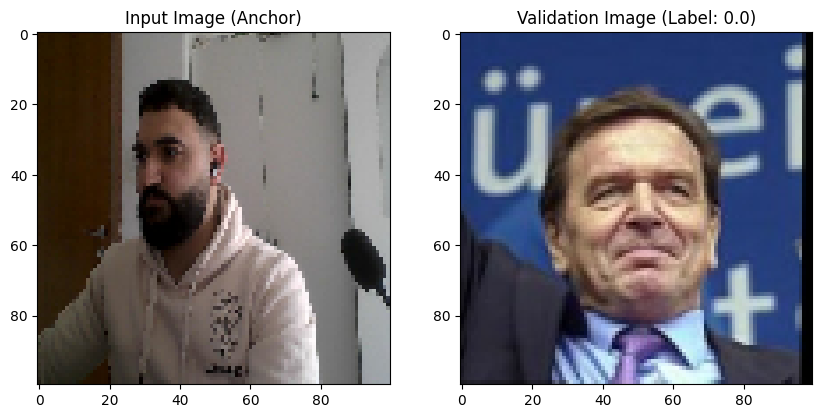

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. Get Image Directories
# We use .take(300) to limit the number of images for faster processing if needed
# but since you have 5 anchors, it will be limited by that anyway.
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files('data/negative/*.jpg').take(300)

# 2. Preprocessing - Scale and Resize
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    return img

# 3. Create Labelled Dataset
# (Anchor, Positive) => 1, (Anchor, Negative) => 0

# We need to know how many samples we have to create the labels
# In eager execution, we can iterate or set a fixed number.
# Since we have few anchors, we zip accordingly.

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(os.listdir(ANC_PATH))))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(os.listdir(ANC_PATH))))))
data = positives.concatenate(negatives)

# 4. Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition (70% train, 30% test)
# Note: With only 10 total pairs (5 pos, 5 neg), this is very small but works for testing the code.
train_data = data.take(round(len(os.listdir(ANC_PATH))*2 * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(os.listdir(ANC_PATH))*2 * 0.7))
test_data = test_data.take(round(len(os.listdir(ANC_PATH))*2 * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 5. Visualize a sample to verify
# Get a batch of data
samples = train_data.as_numpy_iterator()
example = samples.next()

# Plot the first pair in the batch
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Anchor Image
axs[0].imshow(example[0][0])
axs[0].set_title("Input Image (Anchor)")

# Validation Image (Positive or Negative)
axs[1].imshow(example[1][0])
axs[1].set_title(f"Validation Image (Label: {example[2][0]})")

plt.show()

In [25]:
import os

# Check the count of images in the negative folder
neg_path = os.path.join('data', 'negative')

if os.path.exists(neg_path):
    count = len(os.listdir(neg_path))
    print(f"Number of Negative images found: {count}")
else:
    print("Folder data/negative does not exist yet.")

Number of Negative images found: 463


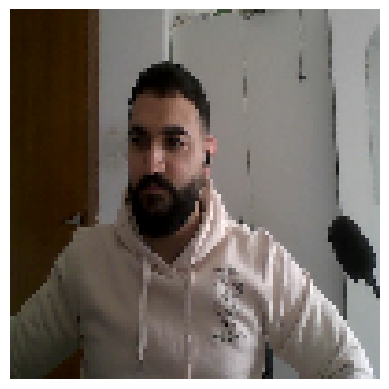

In [32]:
import matplotlib.pyplot as plt

sample = train_data.as_numpy_iterator().next()

plt.imshow(sample[0][0])
plt.axis('off')
plt.show()

# 2.x NEW - Data Augmentation

In [33]:
import tensorflow as tf
import numpy as np

def data_aug(img):
    data = []
    for i in range(9):
        augmented_img = img

        augmented_img = tf.image.stateless_random_brightness(augmented_img, max_delta=0.02, seed=(1,2))
        augmented_img = tf.image.stateless_random_contrast(augmented_img, lower=0.6, upper=1, seed=(1,3))
        augmented_img = tf.image.stateless_random_flip_left_right(augmented_img, seed=(np.random.randint(100),np.random.randint(100)))
        augmented_img = tf.image.stateless_random_saturation(augmented_img, lower=0.9, upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(augmented_img)

    return data

In [34]:
import os
import uuid

In [35]:
import os
import cv2
def augment_and_save(folder_path):
    print(f"Augmenting images in {folder_path}...")

    file_names = os.listdir(folder_path)

    for file_name in file_names:
        img_path = os.path.join(folder_path, file_name)

        img = cv2.imread(img_path)
        if img is None: continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        aug_images = data_aug(img)
        for i, aug_img in enumerate(aug_images):
            aug_img = aug_img.numpy().astype(np.uint8)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

            new_filename = f"aug_{i}_{file_name}"
            cv2.imwrite(os.path.join(folder_path, new_filename), aug_img)

augment_and_save(os.path.join('data', 'anchor'))
augment_and_save(os.path.join('data', 'positive'))

print("Done! Data augmentation complete.")

Augmenting images in data/anchor...
Augmenting images in data/positive...
Done! Data augmentation complete.


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [36]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

dir_test = anchor.as_numpy_iterator()

print(dir_test.next())

b'data/anchor/aug_1_d993a8a2-0360-11f1-bb36-0242ac1c000c.jpg'


## 3.2 Preprocessing - Scale and Resize

Testing preprocess on: data/anchor/aug_8_dc524e4a-0360-11f1-bb36-0242ac1c000c.jpg


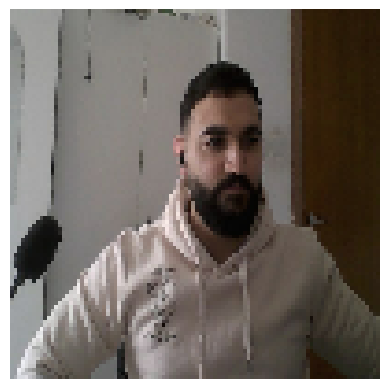

Image shape: (100, 100, 3)


In [37]:
import os
import matplotlib.pyplot as plt

anchor_files = os.listdir(os.path.join('data', 'anchor'))

if len(anchor_files) > 0:
    test_image_name = anchor_files[0]
    test_image_path = os.path.join('data', 'anchor', test_image_name)

    print(f"Testing preprocess on: {test_image_path}")

    img = preprocess(test_image_path)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Image shape: {img.shape}")
else:
    print("Error: No images found in data/anchor")

In [38]:
img.numpy().max()

np.float32(0.97745097)

In [40]:
import os

# 1. Calculate the actual number of images to ensure no length errors
anc_len = len(os.listdir(ANC_PATH))
neg_len = len(os.listdir(NEG_PATH))

print(f"Number of anchors: {anc_len}")

# 2. Create Labels based on the actual count
# Create a dataset of '1's for positive pairs (matching anchor count)
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(anc_len))

# Create a dataset of '0's for negative pairs (matching anchor count)
# We use anc_len here to ensure we have a balanced 50/50 split of positive and negative samples
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(anc_len))

# 3. Zip the data together
# (Anchor, Positive, Label=1)
positives = tf.data.Dataset.zip((anchor, positive, positive_labels))

# (Anchor, Negative, Label=0)
negatives = tf.data.Dataset.zip((anchor, negative, negative_labels))

# 4. Concatenate everything into a single dataset
data = positives.concatenate(negatives)

print("Data combined successfully!")

Number of anchors: 50
Data combined successfully!


In [41]:
samples = data.as_numpy_iterator()

In [42]:
exampple = samples.next()

In [43]:
exampple

(b'data/anchor/aug_5_d6ae3c60-0360-11f1-bb36-0242ac1c000c.jpg',
 b'data/positive/aug_7_eb53d5b2-0360-11f1-bb36-0242ac1c000c.jpg',
 np.float32(1.0))

## 3.4 Build Train and Test Partition

In [45]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [46]:
res = preprocess_twin(*exampple)

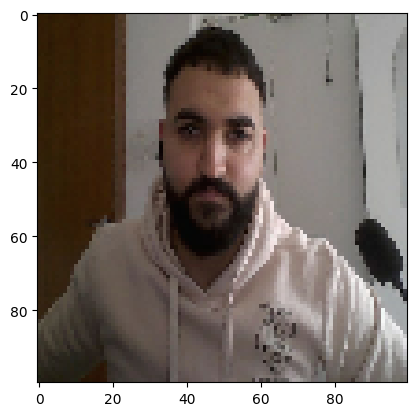

In [47]:
plt.imshow(res[1])

In [48]:
res[2]

np.float32(1.0)

In [49]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [50]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [51]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [52]:
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.models import Model

def make_embedding():
    # 1. Input Layer (Shape matches our resized images: 100x100x3)
    inp = Input(shape=(100, 100, 3), name='input_image')

    # 2. First Convolutional Block
    # 64 filters, 10x10 kernel, ReLU activation
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # 3. Second Convolutional Block
    # 128 filters, 7x7 kernel
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # 4. Third Convolutional Block
    # 128 filters, 4x4 kernel
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # 5. Fourth Convolutional Block
    # 256 filters, 4x4 kernel
    c4 = Conv2D(256, (4,4), activation='relu')(m3)

    # 6. Flatten Layer to convert 3D feature map to 1D vector
    f1 = Flatten()(c4)

    # 7. Dense Layer (The actual embedding vector)
    # 4096 units, Sigmoid activation to keep values between 0 and 1
    d1 = Dense(4096, activation='sigmoid')(f1)

    # 8. Create and return the model
    return Model(inputs=[inp], outputs=[d1], name='embedding')

# Create the model instance
embedding = make_embedding()

# Print the model summary to check the architecture
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Custom L1 Distance Layer
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Calculate the absolute difference between the two embeddings
        return tf.math.abs(input_embedding - validation_embedding)

# Test the layer (optional)
l1 = L1Dist()
# l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [55]:
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.models import Model

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # Block 1
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Block 2
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Block 3
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Block 4
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)

    # Dense Layer
    d1 = Dense(4096, activation='sigmoid')(f1)

    # التصحيح هنا: outputs=d1 بدلاً من outputs=[d1]
    return Model(inputs=[inp], outputs=d1, name='embedding')

# إعادة بناء الموديل
embedding = make_embedding()

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def make_siamese_model():

    # 1. Handle Inputs
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # 2. Combine Distance Component
    # Pass input image through the embedding model
    # (embedding model was defined in step 4.1)
    e1 = embedding(input_image)
    # Pass validation image through the embedding model
    e2 = embedding(validation_image)

    # 3. Calculate Distance
    # Combine the embeddings using the L1 Distance layer
    siamese_layer = L1Dist()

    # This acts as the "distance" between the two images
    distances = siamese_layer(e1, e2)

    # 4. Classification Layer
    # A dense layer with sigmoid activation to output a binary result (0 or 1)
    classifier = Dense(1, activation='sigmoid')(distances)

    # 5. Build and return the final model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Create the specific Siamese model instance
siamese_model = make_siamese_model()

# Check the summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [57]:
import tensorflow as tf

# 1. Setup Loss Function
# Binary Crossentropy is used because we are doing binary classification (Same/Not Same)
binary_cross_loss = tf.losses.BinaryCrossentropy()

# 2. Setup Optimizer
# Adam optimizer with a learning rate of 0.0001 (1e-4)
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [58]:
import os

# 1. Define directory to save checkpoints
checkpoint_dir = './training_checkpoints'

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# 2. Setup Checkpoint Prefix
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 3. Create Checkpoint Object
# We save both the optimizer state (opt) and the model (siamese_model)
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

print(f"Checkpoints will be saved to: {checkpoint_dir}")

Checkpoints will be saved to: ./training_checkpoints


## 5.3 Build Train Step Function

In [59]:
@tf.function
def train_step(batch):

    # 1. Record all operations for Automatic Differentiation
    with tf.GradientTape() as tape:
        # Get Anchor and Positive/Negative image
        # X will contain [Anchor, Validation Image]
        X = batch[:2]
        # Get Label (1 or 0)
        y = batch[2]

        # 2. Forward Pass
        # Pass images to the model to get prediction (yhat)
        # training=True is important for layers like Dropout/BatchNorm
        yhat = siamese_model(X, training=True)

        # 3. Calculate Loss
        # Compare actual label (y) with prediction (yhat)
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # 4. Calculate Gradients
    # Calculate how much we need to adjust weights to minimize loss
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # 5. Apply Gradients (Update Weights)
    # Use the optimizer to update the model weights
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss to track progress
    return loss

## 5.4 Build Training Loop

In [60]:
import time

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            progbar.update(idx + 1)

        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# ----------------------------------------------
# Start Training
# ----------------------------------------------
EPOCHS = 50  # You can increase this to 50 or 100 to improve accuracy
print("Starting Training...")
train(train_data, EPOCHS)
print("Training Complete!")

Starting Training...

 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step

 Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step

 Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

 Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

 Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

 Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step

 Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

 Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step

 Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

 Ep

# 6. Evaluate Model

## 6.1 Import Metrics

In [61]:
# Import Precision and Recall metrics
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [62]:
# 1. Initialize the metrics
r = Recall()
p = Precision()

print("Evaluating model on test data...")

# 2. Loop through the test dataset
# test_data was created in step 4
for test_input, test_val, y_true in test_data.as_numpy_iterator():

    # 3. Make Predictions
    # Pass the two images to the model
    yhat = siamese_model.predict([test_input, test_val])

    # 4. Update Metrics
    # Compare prediction (yhat) with actual label (y_true)
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

# 5. Print Results
print(f"\nRecall: {r.result().numpy()}")
print(f"Precision: {p.result().numpy()}")

Evaluating model on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Recall: 1.0
Precision: 1.0


## 6.3 Calculate Metrics

In [63]:
# 1. Print Recall (Ability to find all positive matches)
print("Recall:", r.result().numpy())

# 2. Print Precision (Accuracy of the positive matches found)
print("Precision:", p.result().numpy())

# 3. (Optional) Check what this means
# 1.0 = 100% (Perfect)
# 0.0 = 0% (Failed)
if r.result().numpy() == 1.0 and p.result().numpy() == 1.0:
    print("Great! The model is performing perfectly on the test set.")
else:
    print("The model might need more training or more data.")

Recall: 1.0
Precision: 1.0
Great! The model is performing perfectly on the test set.


## 6.4 Viz Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


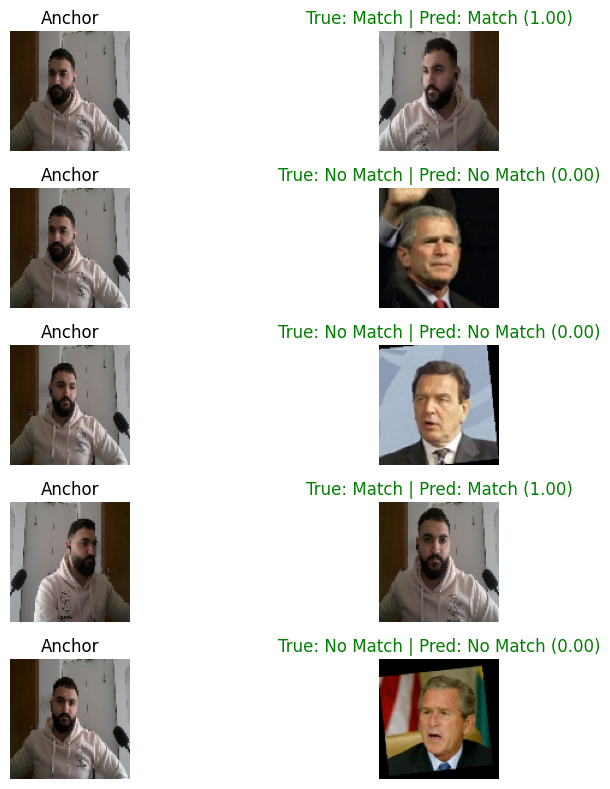

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get a batch of test data
# We fetch the next batch from the iterator
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# 2. Make predictions on this batch
y_hat = siamese_model.predict([test_input, test_val])

# 3. Setup the plot
# We will show the first 5 pairs from the batch
plt.figure(figsize=(10, 8))

for i in range(5):
    # Setup subplot: 5 rows, 2 columns (Anchor, Validation)

    # --- Column 1: Anchor Image ---
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(test_input[i]) # No need to un-normalize if values are 0-1
    plt.title(f"Anchor")
    plt.axis('off')

    # --- Column 2: Validation Image ---
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(test_val[i])

    # Check the prediction score
    score = y_hat[i][0]
    label = y_true[i]

    # Set title color: Green if correct, Red if wrong
    # (Assuming 0.5 threshold)
    prediction_text = "Match" if score > 0.5 else "No Match"
    actual_text = "Match" if label == 1 else "No Match"

    color = 'green' if (score > 0.5) == (label == 1) else 'red'

    plt.title(f"True: {actual_text} | Pred: {prediction_text} ({score:.2f})", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 7. Save Model

In [65]:
# ----------------------------------------------
# 1. Save the Model
# ----------------------------------------------
# Save the model to a single H5 file
siamese_model.save('siamesemodel.h5')
print("Model saved successfully as 'siamesemodel.h5'")

# ----------------------------------------------
# 2. How to Load the Model (For later use)
# ----------------------------------------------
# NOTE: Because we used a custom layer (L1Dist), we must tell Keras about it when loading.
from tensorflow.keras.models import load_model

# Reload the model passing the custom layer in a dictionary
model = load_model('siamesemodel.h5',
                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

print("Model loaded successfully!")
model.summary()

Model saved successfully as 'siamesemodel.h5'


Model loaded successfully!


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [66]:
import os
import shutil

# 1. Create folders for the application data
# verification_images: Where we keep the "True" reference photos
# input_image: Where the webcam will save the current frame
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)

# 2. Move some Anchor images to the verification folder
# We take 50 images from data/anchor to serve as our reference
source_path = os.path.join('data', 'anchor')
dest_path = os.path.join('application_data', 'verification_images')

files = os.listdir(source_path)[:50] # Take first 50 images
for file_name in files:
    shutil.copy(os.path.join(source_path, file_name), os.path.join(dest_path, file_name))

print("Application folders setup correctly!")

Application folders setup correctly!


In [67]:
import numpy as np

def verify(model, detection_threshold, verification_threshold):
    # 1. Build results array
    results = []

    # Path to the verification images
    ver_path = os.path.join('application_data', 'verification_images')
    # Path to the current input image (from webcam)
    inp_path = os.path.join('application_data', 'input_image', 'input_image.jpg')

    # 2. Loop through every image in the verification folder
    for image in os.listdir(ver_path):
        # Preprocess both images
        input_img = preprocess(inp_path)
        validation_img = preprocess(os.path.join(ver_path, image))

        # 3. Make Prediction
        # The model expects a batch, so we expand dims
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # 4. Analysis
    # Detection: How many images passed the individual threshold?
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification: What is the ratio of positive matches? (e.g., 30/50 = 0.6)
    verification = detection / len(os.listdir(ver_path))

    # 5. Final Decision
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV Real Time Verification

In [72]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

# 1. Function to capture an image using browser JavaScript
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Verification Image';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# 2. Setup path and save the image
try:
  # Ensure the directory exists
  input_folder = os.path.join('application_data', 'input_image')
  os.makedirs(input_folder, exist_ok=True)

  # Target filename required for the verify function
  target_path = os.path.join(input_folder, 'input_image.jpg')

  print("Please click 'Capture Verification Image' button below...")
  # Capture the photo
  filename = take_photo(target_path)
  print('Saved to {}'.format(filename))

  # 3. Run Verification
  # We use the 'verify' function we wrote earlier
  # detection_threshold=0.5 (for similarity), verification_threshold=0.5 (proportion of matches)
  results, verified = verify(siamese_model, 0.5, 0.5)

  print("-" * 30)
  if verified:
      print("✅ Verification Successful! (Access Granted)")
      print("You are the correct person!")
  else:
      print("❌ Verification Failed! (Access Denied)")
      print("You are not authorized.")
  print("-" * 30)

except Exception as e:
  print(str(e))

Please click 'Capture Verification Image' button below...


<IPython.core.display.Javascript object>

Saved to application_data/input_image/input_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/s